SVM: Cross Validation, Model Selection, Evaluation on Test Data, and Inference on Similar Email Pairs

Imports, seed, and data loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import load_npz

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import os
import random

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Load preprocessed TF-IDF data
X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf  = load_npz("X_test_tfidf.npz")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape : {X_test_tfidf.shape}")

# Class distribution in train set
unique, counts = np.unique(y_train, return_counts=True)
print("Train class counts (label: count):")
for label, cnt in zip(unique, counts):
    label_name = "ham" if label == 0 else "spam"
    print(f"  {label} ({label_name}): {cnt}")


Train shape: (26882, 5000)
Test shape : (6721, 5000)
Train class counts (label: count):
  0 (ham): 13151
  1 (spam): 13731


PCA Visualisation (Subsampled Train and Test)

To match the XGBoost notebook, we project a small subset of the high-dimensional TF-IDF features
(5000 dimensions) to 2D using PCA. This helps us see how spam and ham roughly distribute in a
compressed space, while remembering that only a small percentage of the total variance is retained.


PCA explained variance ratio (2D): [0.0194321  0.01791453]
Total variance retained in 2D: 0.03734662545711025


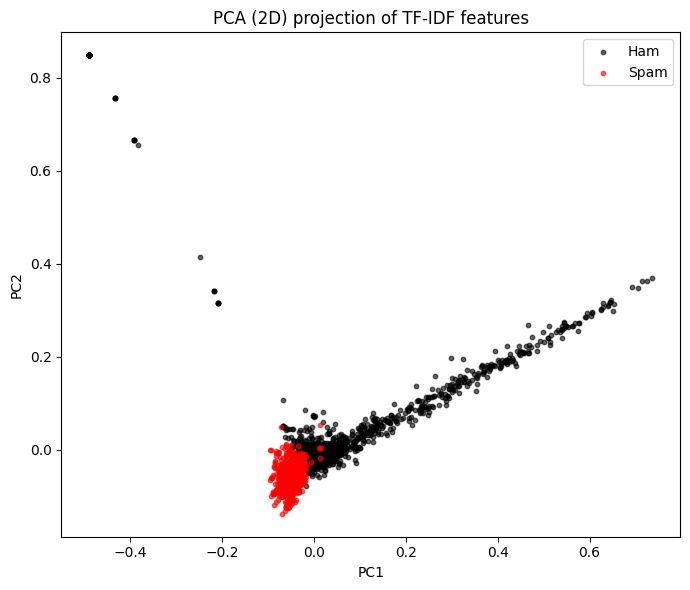

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_pca_2d_from_tfidf(X_sparse, y, sample_size=3000, random_state=SEED):
    n_samples = X_sparse.shape[0]
    if n_samples > sample_size:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n_samples, size=sample_size, replace=False)
        X = X_sparse[idx]
        y_sample = y[idx]
    else:
        X = X_sparse
        y_sample = y

    pca = PCA(n_components=2, random_state=random_state)
    X_dense = X.toarray()          # PCA needs dense data
    X_2d = pca.fit_transform(X_dense)

    print("PCA explained variance ratio (2D):", pca.explained_variance_ratio_)
    print("Total variance retained in 2D:", pca.explained_variance_ratio_.sum())

    # 3) Plot
    plt.figure(figsize=(7, 6))
    mask_spam = (y_sample == 1)
    mask_ham  = (y_sample == 0)

    plt.scatter(X_2d[mask_ham, 0], X_2d[mask_ham, 1],
                c="black", s=10, alpha=0.6, label="Ham")
    plt.scatter(X_2d[mask_spam, 0], X_2d[mask_spam, 1],
                c="red",   s=10, alpha=0.6, label="Spam")

    plt.title("PCA (2D) projection of TF-IDF features")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return X_2d, y_sample, pca

X_train_pca2d, y_train_pca, pca_model = plot_pca_2d_from_tfidf(X_train_tfidf, y_train)


t-SNE Visualization (2D)
PCA first reduces TF-IDF vectors to 50 dimensions for stability, and then t-SNE maps them to 2D to reveal non-linear structure and cluster overlap between spam and ham.


Running t-SNE on 4000 samples...
Step 1: PCA → 50D
Explained variance by first 50 PCA components: 0.21779482070917733
Step 2: t-SNE → 2D 


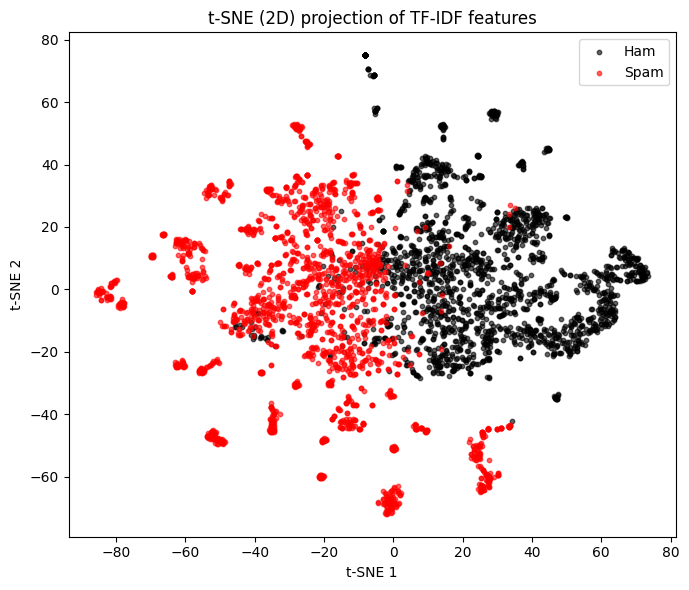

In [4]:
from sklearn.manifold import TSNE
def run_tsne_2d(X_sparse, y, sample_size=4000, random_state=SEED):

    n_samples = X_sparse.shape[0]

    if n_samples > sample_size:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n_samples, size=sample_size, replace=False)
        X = X_sparse[idx]
        y_sample = y[idx]
    else:
        X = X_sparse
        y_sample = y

    print(f"Running t-SNE on {X.shape[0]} samples...")

    n_pca = min(50, X.shape[1])  
    print("Step 1: PCA → 50D")
    pca = PCA(n_components=n_pca, random_state=random_state)
    X_50d = pca.fit_transform(X.toarray())

    print("Explained variance by first 50 PCA components:",
          pca.explained_variance_ratio_.sum())

    print("Step 2: t-SNE → 2D ")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=random_state
    )
    X_tsne_2d = tsne.fit_transform(X_50d)

    # 4. Plotting
    plt.figure(figsize=(7, 6))
    mask_spam = (y_sample == 1)
    mask_ham  = (y_sample == 0)

    plt.scatter(X_tsne_2d[mask_ham, 0], X_tsne_2d[mask_ham, 1],
                c="black", s=10, alpha=0.6, label="Ham")
    plt.scatter(X_tsne_2d[mask_spam, 0], X_tsne_2d[mask_spam, 1],
                c="red", s=10, alpha=0.6, label="Spam")

    plt.title("t-SNE (2D) projection of TF-IDF features")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return X_tsne_2d, y_sample
X_tsne_2d, y_tsne = run_tsne_2d(X_train_tfidf, y_train)


Model Selection with SVM (Linear and RBF)

This section compares linear and RBF SVMs on the training set using cross-validation and hyperparameter tuning to choose the best configuration.

Linear SVM: baseline and hyperparameter tuning

A Linear SVM is a natural first choice for high-dimensional TF-IDF features, so we start with it and tune the regularisation parameter `C` on a log scale using cross-validation.

In [5]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV

baseline_linear = LinearSVC(random_state=42)

linear_cv_scores = cross_val_score(
    baseline_linear,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

print("Baseline Linear SVM")
print("CV ROC-AUC scores:", linear_cv_scores)
print("Mean CV ROC-AUC: {:.4f} ± {:.4f}".format(
    linear_cv_scores.mean(), linear_cv_scores.std())
)

# ----- Grid search for best C on log scale -----
linear_C_values = np.logspace(-3, 2, 6)   # [1e-3, 1e-2, 1e-1, 1, 10, 100]
print("\nLinear SVM C grid:", linear_C_values)

grid_linear = GridSearchCV(
    estimator=LinearSVC(random_state=42),
    param_grid={"C": linear_C_values},
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_linear.fit(X_train_tfidf, y_train)

print("\nBest Linear SVM params:", grid_linear.best_params_)
print("Best Linear SVM CV ROC-AUC:", grid_linear.best_score_)

best_linear_svm = grid_linear.best_estimator_
best_linear_score = grid_linear.best_score_


Baseline Linear SVM
CV ROC-AUC scores: [0.99886515 0.99914181 0.99858202]
Mean CV ROC-AUC: 0.9989 ± 0.0002

Linear SVM C grid: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best Linear SVM params: {'C': np.float64(1.0)}
Best Linear SVM CV ROC-AUC: 0.9988629943912661


RBF SVM: baseline and hyperparameter tuning

Next, an RBF SVM is fitted and tuned over `C` and `gamma` on a logarithmic grid to capture possible non-linear decision boundaries in the TF-IDF space.


In [6]:
from sklearn.svm import SVC

# ----- Baseline RBF SVM with simple CV -----
baseline_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)

rbf_cv_scores = cross_val_score(
    baseline_rbf,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

print("Baseline RBF SVM (C=1.0, gamma='scale')")
print("CV ROC-AUC scores:", rbf_cv_scores)
print("Mean CV ROC-AUC: {:.4f} ± {:.4f}".format(
    rbf_cv_scores.mean(), rbf_cv_scores.std())
)

rbf_C_values     = np.logspace(0, 3, 4)      # [1, 10, 100, 1000]
rbf_gamma_values = np.logspace(-3, 0, 4)     # [0.001, 0.01, 0.1, 1]

print("\nRBF SVM C grid:", rbf_C_values)
print("RBF SVM gamma grid:", rbf_gamma_values)

param_grid_rbf = {
    "C": rbf_C_values,
    "gamma": rbf_gamma_values
}

grid_rbf = GridSearchCV(
    estimator=SVC(kernel="rbf", random_state=42),
    param_grid=param_grid_rbf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_rbf.fit(X_train_tfidf, y_train)

print("\nBest RBF SVM params:", grid_rbf.best_params_)
print("Best RBF SVM CV ROC-AUC:", grid_rbf.best_score_)

best_rbf_svm = grid_rbf.best_estimator_
best_rbf_score = grid_rbf.best_score_


Baseline RBF SVM (C=1.0, gamma='scale')
CV ROC-AUC scores: [0.99892231 0.99921064 0.99846508]
Mean CV ROC-AUC: 0.9989 ± 0.0003

RBF SVM C grid: [   1.   10.  100. 1000.]
RBF SVM gamma grid: [0.001 0.01  0.1   1.   ]
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best RBF SVM params: {'C': np.float64(10.0), 'gamma': np.float64(1.0)}
Best RBF SVM CV ROC-AUC: 0.9990283309586019


For RBF SVM, training is computationally expensive on the full Enron TF-IDF matrix, so we use RandomizedSearchCV with log-scale distributions for C and gamma instead of a full grid search. 

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Log-uniform distributions for C and gamma (similar to lab ranges)
param_dist_rbf = {
    "C": loguniform(1, 1000),        # ~ [1, 1000] on log scale
    "gamma": loguniform(1e-3, 1)     # ~ [1e-3, 1] on log scale
}

rbf_random = RandomizedSearchCV(
    estimator=SVC(kernel="rbf", random_state=42),
    param_distributions=param_dist_rbf,
    n_iter=15,               # you can set 10 if you want it faster
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rbf_random.fit(X_train_tfidf, y_train)

print("\nBest RBF params (RandomizedSearchCV):", rbf_random.best_params_)
print("Best RBF CV ROC-AUC:", rbf_random.best_score_)

best_rbf_svm = rbf_random.best_estimator_
best_rbf_score = rbf_random.best_score_


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END ...................................C=1.0, gamma=0.1; total time=  47.7s
[CV] END ...................................C=1.0, gamma=1.0; total time= 1.7min
[CV] END ................................C=10.0, gamma=0.001; total time= 2.1min
[CV] END ................................C=100.0, gamma=0.01; total time=  24.6s
[CV] END ................................C=100.0, gamma=0.01; total time=  22.3s
[CV] END .................................C=100.0, gamma=1.0; total time= 2.0min
[CV] END .....C=157.0297088405538, gamma=0.06251373574521749; total time=  23.7s
[CV] END ....C=1.4936568554617629, gamma=0.39676050770529875; total time=  37.8s
[CV] END ....C=1.4936568554617629, gamma=0.39676050770529875; total time=  39.4s
[CV] END .....C=1.1527987128232398, gamma=0.8123245085588685; total time= 1.3min
[CV] END ...C=19.762189340280063, gamma=0.007476

KeyboardInterrupt: 

## Final SVM Model Selection and Evaluation on Test Data

We now compare the tuned **Linear SVM** and **RBF SVM** using their
cross-validated ROC-AUC scores on the training set. The model with the
higher CV ROC-AUC is chosen as the final SVM classifier.

We then evaluate this selected model on the unseen test set, reporting:
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- Full classification report

This mirrors the evaluation style of the XGBoost notebook so that we can
later compare models fairly.



In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Collect available models and their CV ROC-AUC scores
model_candidates = {}

if "best_linear_svm" in globals() and "best_linear_score" in globals():
    model_candidates["Linear SVM"] = (best_linear_svm, best_linear_score)

if "best_rbf_svm" in globals() and "best_rbf_score" in globals():
    model_candidates["RBF SVM"] = (best_rbf_svm, best_rbf_score)

if not model_candidates:
    raise RuntimeError("No tuned SVM models found. Make sure you ran the tuning cells.")

print("Cross-validated ROC-AUC (training set):")
for name, (_, cv_score) in model_candidates.items():
    print(f"  {name}: {cv_score:.4f}")

# Select model with best CV ROC-AUC
best_model_name, (best_svm_model, best_cv_score) = max(
    model_candidates.items(), key=lambda kv: kv[1][1]
)

print(f"\nSelected final model: {best_model_name} (CV ROC-AUC = {best_cv_score:.4f})")

# ---- Evaluation on unseen test set ----
y_pred_test = best_svm_model.predict(X_test_tfidf)

# For ROC-AUC we use decision_function (preferred) or probabilities if available
if hasattr(best_svm_model, "decision_function"):
    score_input = best_svm_model.decision_function(X_test_tfidf)
    test_roc_auc = roc_auc_score(y_test, score_input)
elif hasattr(best_svm_model, "predict_proba"):
    proba = best_svm_model.predict_proba(X_test_tfidf)[:, 1]
    test_roc_auc = roc_auc_score(y_test, proba)
else:
    test_roc_auc = np.nan

test_accuracy  = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall    = recall_score(y_test, y_pred_test)
test_f1        = f1_score(y_test, y_pred_test)

print("\n=== Test set performance (final SVM) ===")
print(f"Accuracy   : {test_accuracy:.4f}")
print(f"Precision  : {test_precision:.4f}")
print(f"Recall     : {test_recall:.4f}")
print(f"F1-score   : {test_f1:.4f}")
print(f"ROC-AUC    : {test_roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_test, target_names=["ham", "spam"]))


## Confusion Matrix on Test Set

To better understand the types of errors made by the final SVM model,
we plot a confusion matrix on the test data (ham vs spam).


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["ham", "spam"]
)

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

print("\nConfusion matrix (rows = true, cols = predicted):")
print(cm)


## Saving the Final SVM Model

We save the selected SVM model to disk so that it can be reused for
further comparison (e.g., against XGBoost) and for inference on new
emails without retraining.


In [ ]:
import pickle

with open("best_svm_model.pkl", "wb") as f:
    pickle.dump(best_svm_model, f)

print("Final SVM model saved to 'best_svm_model.pkl'")


## Inference on 20 Similar Email Pairs 

We now evaluate the final SVM model on the same 20 carefully crafted
email pairs . Each pair contains:

- One *ham* email and one *spam* email with similar surface wording
  but different intent.
- Texts are transformed using the shared TF-IDF vectorizer
  (`tfidf_vectorizer.pkl`).

For each email, we report:
- True label (ham/spam)
- Predicted label by SVM
- A confidence score derived from the SVM decision function
- Whether the prediction is correct

We also plot the 40 emails (20 pairs) in a 2D t-SNE space to visualize
how the SVM separates ham and spam at this fine-grained level.


Total emails: 44 (should be 2 × number_of_pairs)

Accuracy on the 20 ham/spam pairs: 81.82% (36/44)


/var/folders/5n/kb6rzsrd09n8j2666r3_0c0h0000gn/T/ipykernel_40148/619035024.py:162: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(ham_x, ham_y, c='blue', marker=ham_marker,
/var/folders/5n/kb6rzsrd09n8j2666r3_0c0h0000gn/T/ipykernel_40148/619035024.py:164: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(spam_x, spam_y, c='red', marker=spam_marker,


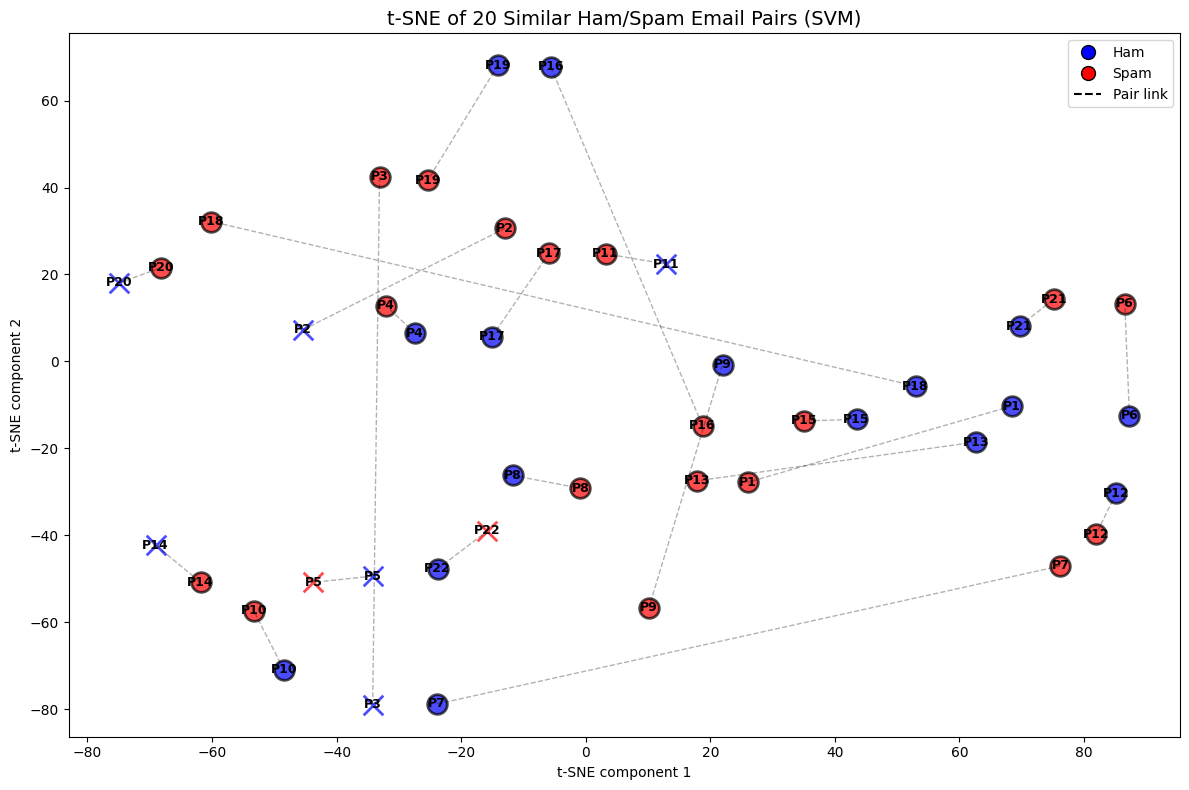


Prediction results for all email pairs (SVM):
 Pair Type                                                   Email_Preview True_Label Predicted Confidence Correct
    1  Ham Meeting scheduled for tomorrow at 3pm in conference room to ...        Ham       Ham      81.1%       ✓
    1 Spam MEETING CONFIRMED! Click here NOW to claim your spot and WIN...       Spam      Spam      57.6%       ✓
    2  Ham Your account statement is ready for review. Please log in to...        Ham      Spam      54.6%       ✗
    2 Spam Your account has WON $50,000! Click here immediately to clai...       Spam      Spam      84.9%       ✓
    3  Ham Thank you for your purchase. Your order will be shipped with...        Ham      Spam      65.8%       ✗
    3 Spam Congratulations! You've been selected for FREE products! Act...       Spam      Spam      80.7%       ✓
    4  Ham Please review the attached document and provide feedback by ...        Ham       Ham      70.6%       ✓
    4 Spam URGENT! Review this do

In [10]:
import numpy as np
import pickle
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

email_pairs = [
    {
        'ham': "Meeting scheduled for tomorrow at 3pm in conference room to discuss quarterly results",
        'spam': "MEETING CONFIRMED! Click here NOW to claim your spot and WIN prizes at 3pm tomorrow!"
    },
    {
        'ham': "Your account statement is ready for review. Please log in to view your balance.",
        'spam': "Your account has WON $50,000! Click here immediately to claim your prize money!"
    },
    {
        'ham': "Thank you for your purchase. Your order will be shipped within 2 business days.",
        'spam': "Congratulations! You've been selected for FREE products! Act now, limited time offer!"
    },
    {
        'ham': "Please review the attached document and provide feedback by end of week.",
        'spam': "URGENT! Review this document to claim your inheritance of $5 MILLION dollars!"
    },
    {
        'ham': "Your subscription has been renewed successfully. No further action is required.",
        'spam': "Your subscription will be CANCELLED! Click now to keep your access and avoid charges!"
    },
    {
        'ham': "Reminder: The team lunch is scheduled for Friday at 1pm in the main cafeteria.",
        'spam': "FREE LUNCH for winners! Click here to claim your gift card and join our special event!"
    },
    {
        'ham': "We received your support ticket and will respond within 24–48 hours.",
        'spam': "Support ALERT! Your device is infected. Click this link NOW to clean your system!"
    },
    {
        'ham': "Please update your contact details in the HR portal before the end of the month.",
        'spam': "Update your details to receive unexpected CASH REWARDS! Last chance—click here!"
    },
    {
        'ham': "Your interview is confirmed for Monday at 10am. Please arrive 10 minutes early.",
        'spam': "You have been PRE-APPROVED! Apply now for your dream job with no interview required!"
    },
    {
        'ham': "Invoice for your recent purchase is attached. Please process the payment as usual.",
        'spam': "OVERDUE INVOICE! Pay IMMEDIATELY to avoid legal action. Click here to settle now!"
    },
    {
        'ham': "Thank you for attending the webinar. A recording will be shared shortly.",
        'spam': "Thanks for attending! CLAIM YOUR BONUS REWARD now by clicking this special link!"
    },
    {
        'ham': "The maintenance window is scheduled for Saturday between 2am and 4am.",
        'spam': "System MAINTENANCE ALERT: Your access will be revoked unless you verify your account now!"
    },
    {
        'ham': "Here is the agenda for tomorrow’s strategy meeting. Let me know if anything is missing.",
        'spam': "WIN BIG in our strategy game! Click here to play and claim instant cash rewards!"
    },
    {
        'ham': "Your package has been delivered. Reply if you did not receive it.",
        'spam': "PACKAGE HELD at customs! Pay the small fee now to release your parcel and avoid penalties!"
    },
    {
        'ham': "Can we move our one-on-one meeting to Thursday afternoon?",
        'spam': "ONE-TIME OFFER: Move your debt to 0% interest. Click now to secure this exclusive deal!"
    },
    {
        'ham': "Please find attached your course schedule for the upcoming semester.",
        'spam': "You have been SELECTED for an exclusive training with instant certification! Enrol now!"
    },
    {
        'ham': "We appreciate your feedback on our service. It helps us improve.",
        'spam': "Your feedback WON you a prize! Click this link to claim your reward before it expires!"
    },
    {
        'ham': "Can you send me the presentation slides from yesterday's meeting? Thanks.",
        'spam': "SEND ME YOUR BANK DETAILS NOW to receive your lottery winnings! ACT FAST!"
    },
    {
        'ham': "Let's schedule a call next week to discuss the contract terms and pricing.",
        'spam': "CALL NOW to claim your FREE VACATION! Limited spots available, ACT IMMEDIATELY!"
    },
    {
        'ham': "The quarterly report shows steady growth in all departments this year.",
        'spam': "SHOCKING GROWTH in your bank account! Click to see how you WON millions!"
    },
    {
        'ham': "Please confirm your attendance at the conference by replying to this email.",
        'spam': "CONFIRM YOUR EMAIL to unlock FREE MONEY! Reply now with your credit card!"
    },
    {
        'ham': "Your password has been successfully updated. Contact support if you need help.",
        'spam': "YOUR PASSWORD EXPIRED! Update NOW by entering your banking details here!"
    }
]

# ---- 2. Flatten into arrays of texts and labels ----
emails = []
labels = []

for pair in email_pairs:
    emails.append(pair['ham'])
    labels.append(0)  # ham
    emails.append(pair['spam'])
    labels.append(1)  # spam

emails = np.array(emails)
labels = np.array(labels)

print(f"Total emails: {len(emails)} (should be 2 × number_of_pairs)")

# ---- 3. Load TF-IDF vectorizer and transform emails ----
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

emails_tfidf = tfidf_vectorizer.transform(emails)

# ---- 3b. Load the trained SVM model ----
with open("best_svm_model.pkl", "rb") as f:
    best_svm_model = pickle.load(f)
    
# ---- 4. Predictions and a simple confidence score ----
svm_predictions = best_svm_model.predict(emails_tfidf)
correct_flags = (svm_predictions == labels)

# Use decision_function to derive a pseudo-confidence between 0.5 and 1.0
if hasattr(best_svm_model, "decision_function"):
    raw_scores = best_svm_model.decision_function(emails_tfidf)
    # For binary SVM, raw_scores is (n_samples,)
    confidence = 1.0 / (1.0 + np.exp(-np.abs(raw_scores)))
else:
    # Fallback: all confidences = 1.0 if we don't have a margin
    confidence = np.ones_like(svm_predictions, dtype=float)

pair_accuracy = correct_flags.mean() * 100.0
print(f"\nAccuracy on the 20 ham/spam pairs: {pair_accuracy:.2f}% "
      f"({correct_flags.sum()}/{len(correct_flags)})")

tsne = TSNE(n_components=2, perplexity=5, random_state=42, max_iter=1000)
emails_2d = tsne.fit_transform(emails_tfidf.toarray())

fig, ax = plt.subplots(figsize=(12, 8))

for pair_id in range(len(email_pairs)):
    ham_idx = pair_id * 2
    spam_idx = pair_id * 2 + 1

    ham_x, ham_y = emails_2d[ham_idx]
    spam_x, spam_y = emails_2d[spam_idx]

    # Connect ham and spam from the same pair
    ax.plot([ham_x, spam_x], [ham_y, spam_y], 'k--', alpha=0.3, linewidth=1)

    # Markers: circle if correct, 'x' if misclassified
    ham_correct = correct_flags[ham_idx]
    spam_correct = correct_flags[spam_idx]

    ham_marker = 'o' if ham_correct else 'x'
    spam_marker = 'o' if spam_correct else 'x'

    ax.scatter(ham_x, ham_y, c='blue', marker=ham_marker,
               s=200, alpha=0.7, edgecolors='k', linewidth=2)
    ax.scatter(spam_x, spam_y, c='red', marker=spam_marker,
               s=200, alpha=0.7, edgecolors='k', linewidth=2)

    # Label with pair index
    ax.text(ham_x, ham_y, f"P{pair_id+1}", ha='center', va='center',
            fontsize=9, fontweight='bold')
    ax.text(spam_x, spam_y, f"P{pair_id+1}", ha='center', va='center',
            fontsize=9, fontweight='bold')

from matplotlib.lines import Line2D
legend_items = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
           markeredgecolor='k', markersize=10, label='Ham'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
           markeredgecolor='k', markersize=10, label='Spam'),
    Line2D([0], [0], color='k', linestyle='--', label='Pair link')
]

ax.legend(handles=legend_items, fontsize=10)
ax.set_title("t-SNE of 20 Similar Ham/Spam Email Pairs (SVM)", fontsize=14)
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.tight_layout()
fig.savefig("tsne_plot_svm.png", dpi=300, bbox_inches='tight')
plt.show()

rows = []
for i, pair in enumerate(email_pairs):
    ham_idx = 2 * i
    spam_idx = 2 * i + 1

    rows.append({
        "Pair": i + 1,
        "Type": "Ham",
        "Email_Preview": pair["ham"][:60] + "...",
        "True_Label": "Ham",
        "Predicted": "Ham" if svm_predictions[ham_idx] == 0 else "Spam",
        "Confidence": f"{confidence[ham_idx] * 100:.1f}%",
        "Correct": "✓" if correct_flags[ham_idx] else "✗"
    })

    rows.append({
        "Pair": i + 1,
        "Type": "Spam",
        "Email_Preview": pair["spam"][:60] + "...",
        "True_Label": "Spam",
        "Predicted": "Ham" if svm_predictions[spam_idx] == 0 else "Spam",
        "Confidence": f"{confidence[spam_idx] * 100:.1f}%",
        "Correct": "✓" if correct_flags[spam_idx] else "✗"
    })

analysis_df = pd.DataFrame(rows)
print("\nPrediction results for all email pairs (SVM):")
print(analysis_df.to_string(index=False))
